# Homework #06

In [1]:
import secrets
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
from scipy import stats

In [2]:
data_path = Path().resolve().parent / "data"

## Bayes

In [3]:
# Random seed for reproducibility
# secrets.randbits(128) # 208905213533139122735706682150229709525
rng = np.random.default_rng(208905213533139122735706682150229709525)
indices_train = rng.choice(5000, 2500, replace=False)
indices_test = rng.choice(800, 400, replace=False)
flag_full_dataset = False  # If it is True it will use full train and test datasets 

In [4]:
train_list = []  # Auxiliary list of train datasets
for f in data_path.glob("train*.txt"):
    raw_data = np.loadtxt(f) if flag_full_dataset else np.loadtxt(f)[indices_train, :]  # Sample or full dataset
    target = raw_data[:, [0]]  # Target values, i.e. digit 
    features = (raw_data[:, 1:] / raw_data[:, 1:].max(axis=1, keepdims=True)).astype(bool).astype(int)  # Pixels values, normalization and then cast to 0 and 1
    train_list.append(np.hstack((target, features)))  # Add to the temp list
train_data = np.vstack(train_list)  # Concatenate train datasets
train_data.shape

(25000, 785)

In [5]:
# Similar to train dataset
test_list = []
for f in data_path.glob("test*.txt"):
    raw_data = np.loadtxt(f) if flag_full_dataset else np.loadtxt(f)[indices_test, :]
    target = raw_data[:, [0]]
    features = (raw_data[:, 1:] / raw_data[:, 1:].max(axis=1, keepdims=True)).astype(bool).astype(int)
    test_list.append(np.hstack((target, features)))
test_data = np.vstack(test_list)
test_data.shape

(4000, 785)

In [6]:
# Split datasets into features matrices and target vectors
X_train = train_data[:, 1:]
y_train = train_data[:, 0].astype(int)
X_test = test_data[:, 1:]
y_test = test_data[:, 0].astype(int)

In [7]:
y_train_unique, y_train_count = np.unique(y_train, return_counts=True)  # Get unique targets values (digits) and its count
prob_v_dict = dict(zip(y_train_unique.astype(int), y_train_count / y_train.size))  # Dictionary with $prob(v_j)$

m = 1
p1 = 1 / 2  # Values can be 0 or 1
p2 = 1 / 4  # Values can be 00, 01, 10, 00

prob_a_0_dict = {}  # Dictionary with $p(a_i | v_j)$ when $a_i$ = 0 for each $v_j$
prob_a_1_dict = {}  # Dictionary with $p(a_i | v_j)$ when $a_i$ = 1 for each $v_j$
prob_pairs_dict = {}  # Dictionary of dictrionaries of each combination $p(a_i | a_{i+1}, v_j)$ for each $v_j$.
for j in y_train_unique:
    X_train_target_j = X_train[y_train == j]
    prob_a_0_dict[j] = ((X_train_target_j == 0).sum(axis=0) + m * p1) / (X_train_target_j.shape[0] + m)
    prob_a_1_dict[j] = ((X_train_target_j == 1).sum(axis=0) + m * p1) / (X_train_target_j.shape[0] + m)
    prob_pairs_dict[j] = {}
    for k in range(X_train_target_j.shape[1] - 1):
        X_train_target_j_k = X_train_target_j[:, k:k+2]
        pairs, pairs_count = np.unique(X_train_target_j_k, axis=0, return_counts=True)
        denom = (X_train_target_j_k.shape[0] + m)
        d = {(0, 0): m * p2 / denom, (0, 1): m * p2 / denom, (1, 0): m * p2 / denom, (1, 1): m * p2 / denom}  # Dummy
        for pair in range(pairs.shape[0]):
            d[tuple(pairs[pair])] = (pairs_count[pair] + m * p2) / denom
        prob_pairs_dict[j][k] = d

In [8]:
y_pred = np.empty(shape=X_test.shape[0])  # Vector of predictions
for i in range(X_test.shape[0]):  # Iterate over each sample
    X_test_i = X_test[i, :]
    prob_dict = {}  # Dictionary of $p(a_1, ..., a_n | v_j) p(v_j)$ for each $v_j$
    for j in y_train_unique:
        # p(a_n | v_j)
        if X_test_i[-1] == 0:
            prob = prob_a_0_dict[j][-1]
        else:
            prob = prob_a_1_dict[j][-1]
        # p(a_i | a_{i+1}, v_j)
        for k in range(X_test_i.shape[0] - 1):
            a_k = X_test_i[k]
            a_k_plus_1 = X_test_i[k]
            prob *= prob_pairs_dict[j][k][a_k, a_k_plus_1]
        prob_dict[j] = prob * prob_v_dict[j]
    y_pred[i] = int(max(prob_dict, key=prob_dict.get))  # Argmax

In [9]:
n = y_pred.size
error_h = sum(y_pred == y_test) / n
sigma = np.sqrt(error_h * (1 - error_h) / n)
print(f"Accuracy was {error_h:.2%} and with approximately 95% probability the true error lies in the interval [{error_h - 1.96 * sigma:.4f}, {error_h + 1.96 * sigma:.4f}]")

Accuracy was 83.50% and with approximately 95% probability the true error lies in the interval [0.8235, 0.8465]


/tmp/ipykernel_12365/310079026.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


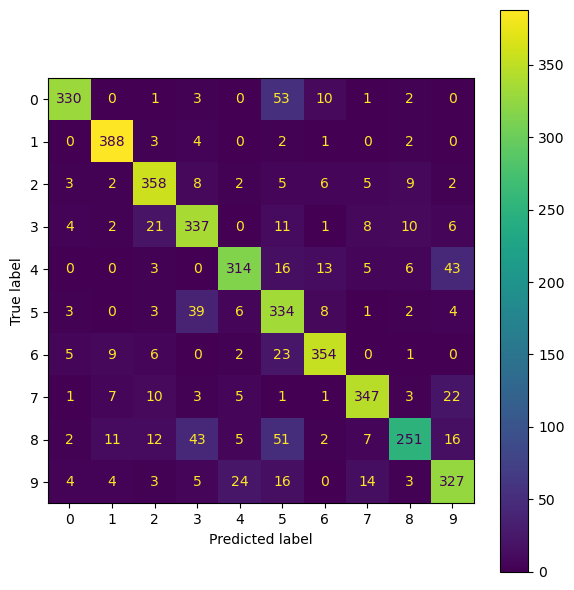

In [10]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    ax=ax
)
fig.tight_layout()
fig.savefig(f"confusion_matrix_fulldata_{flag_full_dataset}.png", dpi=300)
fig.show()

/tmp/ipykernel_12365/1516727643.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


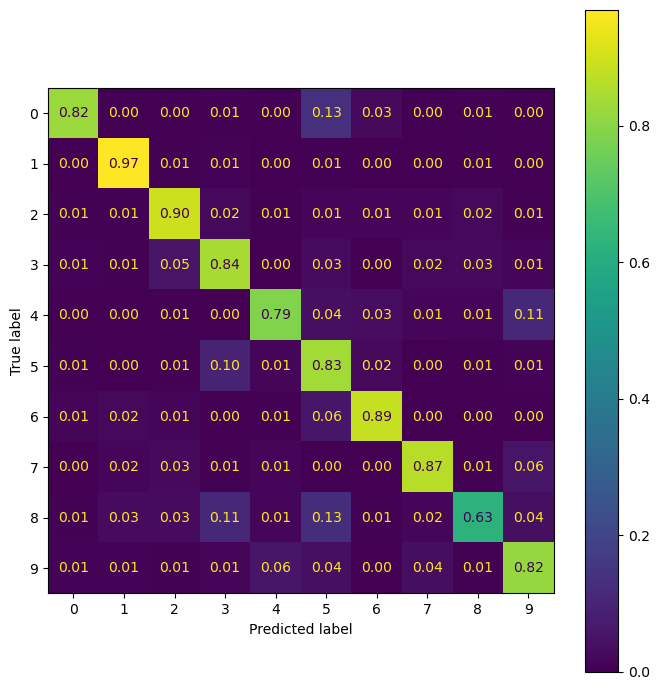

In [11]:
# Confusion matrix - row normalization
fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    normalize="true",
    values_format=".2f",
    ax=ax
)
fig.tight_layout()
fig.savefig(f"confusion_matrix_row_normalize_fulldata_{flag_full_dataset}.png", dpi=300)
fig.show()

## EM

In [12]:
em_filepath = data_path / "Alonso.txt"
x = np.loadtxt(em_filepath)
display(x.shape)
display(x.min())
display(x.max())

(2000,)

-3.8761745

3.8702511

In [22]:
sigma = 1
mu1_0, mu2_0 = -3, 0

[]

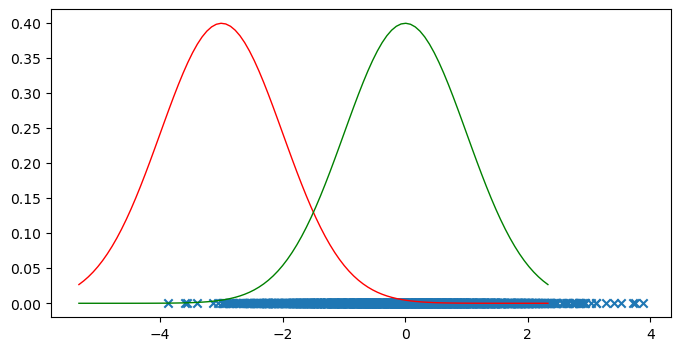

In [23]:
mu1 = mu1_0
mu2 = mu2_0
x_min = np.min([stats.norm.ppf(0.01, loc=mu1, scale=sigma), stats.norm.ppf(0.01, loc=mu2, scale=sigma)])
x_max = np.max([stats.norm.ppf(0.99, loc=mu1, scale=sigma), stats.norm.ppf(0.99, loc=mu2, scale=sigma)])
x_linspace = np.linspace(x_min, x_max, 100)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x_linspace, stats.norm.pdf(x_linspace, loc=mu1, scale=sigma), 'r-', lw=1, label='norm pdf 1')
ax.plot(x_linspace, stats.norm.pdf(x_linspace, loc=mu2, scale=sigma), 'g-', lw=1, label='norm pdf 2')
ax.scatter(x, np.zeros_like(x), marker="x")
ax.plot()

In [37]:
mu1_0, mu2_0 = -10, 10
sigma = 1
tol = 1e-8
max_iterations = 100000

mu1 = mu1_0
mu2 = mu2_0
h = [mu1, mu2] 
h_array = [h]
for _ in range(max_iterations):
    # E-step
    prob_x_mu1 = np.exp(-0.5 * ((x - mu1) / sigma) ** 2)
    prob_x_mu2 = np.exp(-0.5 * ((x - mu2) / sigma) ** 2)
    E_z1 = prob_x_mu1 / (prob_x_mu1 + prob_x_mu2)
    E_z2 = prob_x_mu2 / (prob_x_mu1 + prob_x_mu2)

    # M-step
    mu1_new = np.mean(E_z1 * x)
    mu2_new = np.mean(E_z2 * x)
    if np.linalg.norm([mu1 - mu1_new, mu2 - mu2_new], ord=2) < tol:
        break
    mu1 = mu1_new
    mu2 = mu2_new
    h_array.append([mu1, mu2])
    print(mu1, mu2)

-0.5066498059380969 0.43045649533425695
-0.296441051462091 0.22024774085825097
-0.20149258753781293 0.12529927693397294
-0.14626295767148884 0.07006964706764882
-0.11104999971387872 0.03485668911003873
-0.0877075192234295 0.011514208619589501
-0.0719608890227162 -0.0042324215811238
-0.06125256647231457 -0.014940744131525425
-0.05394321679013743 -0.022250093813702566
-0.04894524013364647 -0.02724807047019353
-0.04552493705352804 -0.03066837355031196
-0.04318339887155706 -0.03300991173228293
-0.041580094972016216 -0.03461321563182378
-0.040482184302586 -0.035711126301254
-0.03973032720621002 -0.036462983397629975
-0.03921544054695468 -0.036977870056885326
-0.038862832884550606 -0.03733047771928939
-0.0386213570810366 -0.03757195352280339
-0.03845598723450596 -0.03773732336933404
-0.0383427369202631 -0.0378505736835769
-0.03826517961866598 -0.037928130985174016
-0.03821206598047438 -0.03798124462336563
-0.0381756921154166 -0.038017618488423395
-0.03815078216457144 -0.038042528439268565
-0

In [ ]:
np.mean()